# Cosine similarity

Logic:
A->Q->A' cosine similarity
* A is an original answer
* Q is a question sintatically generated from A
 * A' is an answer sintatically generated form a Q question
 * now compare original and generated answers and see how similar they are by calculation cosine

In [13]:
import pandas as pd
from tqdm.auto import tqdm

In [15]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [3]:
#load data
url_results_gpt35 = "https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/refs/heads/main/03-evaluation/rag_evaluation/data/results-gpt35.csv"
url_results_gpt4o = "https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/refs/heads/main/03-evaluation/rag_evaluation/data/results-gpt4o.csv"

df_gpt35 =  pd.read_csv(url_results_gpt35)
df_gpt4o =  pd.read_csv(url_results_gpt4o)

In [4]:
results_gpt4o = df_gpt4o.to_dict(orient = "records")

In [6]:
record = results_gpt4o[0]
record

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [8]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [16]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [17]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [18]:
#gtp-3.5

results_gpt35 = df_gpt35.to_dict(orient = "records")

In [19]:
similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [20]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546505
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

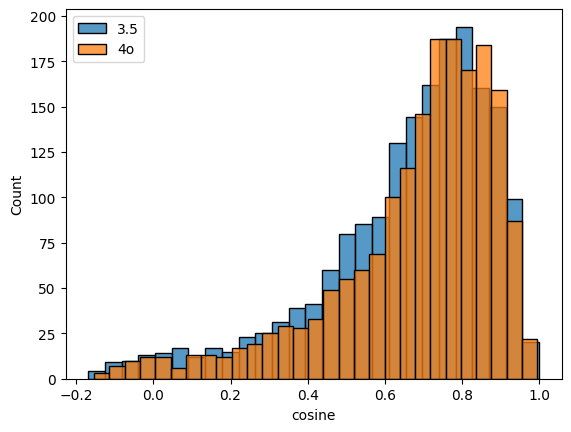

In [24]:
sns.histplot(df_gpt35['cosine'], label = '3.5')
sns.histplot(df_gpt4o['cosine'], label = '4o')
plt.legend()
plt.show()

# LLM-as-a-Judge

In [25]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [26]:
df_sample = df_gpt4o.sample(n=150, random_state=1)
df_sample

,answer_llm,answer_orig,document,question,course,cosine
726,The syntax for using `precision_recall_fscore_...,Scikit-learn offers another way: precision_rec...,403bbdd8,What is the syntax for using precision_recall_...,machine-learning-zoomcamp,0.881816
1662,"To avoid pickle errors when using waitress, yo...",When running a docker container with waitress ...,236864c2,How should I modify my scripts to avoid pickle...,machine-learning-zoomcamp,0.742705
834,To launch a container image in interactive mod...,Launch the container image in interactive mode...,63a81b57,What command launches a container image in int...,machine-learning-zoomcamp,0.841398
1234,"Yes, you can make a pull request for homework ...",Pytorch is also a deep learning framework that...,c4ff26e5,Can we make a pull request for homework soluti...,machine-learning-zoomcamp,0.701560
1323,The pip version error in this week's serverles...,When running docker build -t dino-dragon-model...,42c09143,What might be the cause of the pip version err...,machine-learning-zoomcamp,0.303531
...,...,...,...,...,...,...
161,If GitHub no longer supports password authenti...,I had a problem when I tried to push my code f...,7b907071,What should I do if password authentication fo...,machine-learning-zoomcamp,0.820745
60,You can find instructions to install TensorFlo...,Here is an article that worked for me: https:/...,34b7fd35,Where can I find instructions to install Tenso...,machine-learning-zoomcamp,0.452779
655,In the context of calculating the AUC score us...,When calculating the ROC AUC score using sklea...,7d40f6f6,What is the role of y_true in calculating the ...,machine-learning-zoomcamp,0.806522
1386,To solve the issue of Jupyter notebook not rec...,On vscode running jupyter notebook. After I ‘p...,ea2e7458,How did Quinn Avila solve the issue of Jupyter...,machine-learning-zoomcamp,0.838745


In [28]:
samples = df_sample.to_dict(orient = 'records')

In [29]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\n\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```\n\nHere, `y_val` represents the true labels, `y_val_pred` represents the predicted labels, and `zero_division=0` specifies how to handle divisions by zero. This will return the precision, recall, F1 score, and support for each class.',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.8818159103393555}

In [30]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val

In [ ]:
#answer = llm(prompt, model = XXX)